<a href="https://colab.research.google.com/github/kunwarshivam/ML-Cyber-Sec-Lab3/blob/main/ML_CyberSec_Lab3_KSS519.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kunwar Shivam Srivastav

KSS519

Lab3


## Import package

In [ ]:
import sys
import h5py
import warnings
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import keras

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
warnings.filterwarnings("ignore")

Mounted at /content/gdrive


## 1. bd_net

Let's see the cleaning accuracy, attack success rate, and summary of bd_net

In [ ]:
cleanDataPath = '/content/gdrive/MyDrive/ml-cs-lab3/cl/valid.h5'
poisonedDataPath = '/content/gdrive/MyDrive/ml-cs-lab3/bd/bd_valid.h5'
modelPath = '/content/gdrive/MyDrive/ml-cs-lab3/models/bd_net.h5'
initialCleanAccuracy = 0
attackSuccessRate = 0

In [ ]:
def loadData(path):
    data = h5py.File(path, 'r')
    xData = np.array(data['data'])
    yData = np.array(data['label'])
    xData = xData.transpose((0,2,3,1))
    return xData, yData

In [ ]:
def getAccuracyAndASR():
    bdModel = keras.models.load_model(modelPath)

    cleanXTest, cleanYTest = loadData(cleanDataPath)
    cleanLabelP = np.argmax(bdModel.predict(cleanXTest), axis=1)
    cleanAccuracy = np.mean(np.equal(cleanLabelP, cleanYTest))*100

    badXTest, badYTest = loadData(poisonedDataPath)
    badLabelP = np.argmax(bdModel.predict(badXTest), axis=1)
    asr = np.mean(np.equal(badLabelP, badYTest))*100
    
    return cleanAccuracy, asr

In [ ]:
initialCleanAccuracy, attackSuccessRate = getAccuracyAndASR()
print('Clean Classification Accuracy =', initialCleanAccuracy)
print('Attack Success Rate =', attackSuccessRate)

Clean Classification Accuracy = 98.64899974019225
Attack Success Rate = 100.0


In [ ]:
model = keras.models.load_model(modelPath)

In [ ]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

Let's see the images from the clean data

In [ ]:
xData, yData = loadData(cleanDataPath)

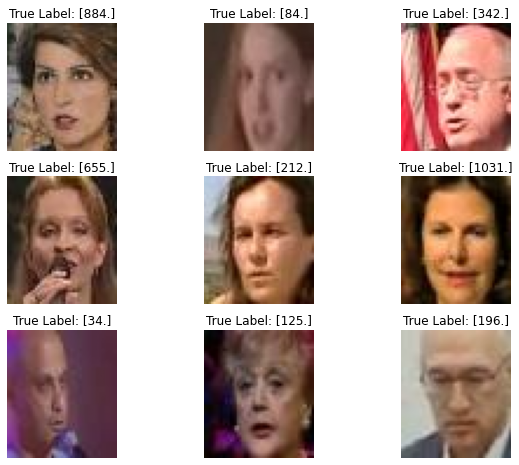

In [ ]:
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(xData.shape[0], size=1)
  img, label = (xData[index], yData[index])
  figure.add_subplot(rows, cols, i)
  plt.title("True Label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

And now, the images from the poisoned data

In [ ]:
xPoisonedData, yPoisonedData = loadData(poisonedDataPath)

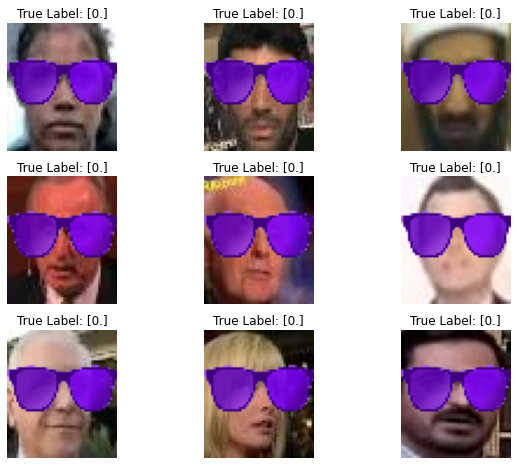

In [ ]:
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(xPoisonedData.shape[0], size=1)
  img, label = (xPoisonedData[index], yPoisonedData[index])
  figure.add_subplot(rows, cols, i)
  plt.title("True Label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

In [ ]:
keras.backend.clear_session()

## Prune Model


To prune the model, we have to check the activation of the last pooling layer. In this case, it is pool_3. We prune the activation witht eh smallest average.
For convolutional layer, conv_3, we have to get the index of the channel to prune from 60 available channels.

In [ ]:
## get the clean and poisoned data
cleanXTest, cleanYTest = loadData(cleanDataPath)
badXTest, badYTest = loadData(poisonedDataPath)

In [ ]:
cleanDataAccuracy = initialCleanAccuracy
modelCopy = keras.models.clone_model(model)
modelCopy.set_weights(model.get_weights()) 

In [ ]:
cleanAccuracies = []
attackSuccessRates = []
savedModels = np.zeros(3,dtype=bool)
prunedChannels = []

In [ ]:
## get the activation from 'pool_3'
layerOutput=modelCopy.get_layer('pool_3').output
intermediateModel=keras.models.Model(inputs=modelCopy.input,outputs=layerOutput)
intermediatePrediction=intermediateModel.predict(cleanXTest)  
temp = np.mean(intermediatePrediction,axis=(0,1,2))
seq = np.argsort(temp)
weight_0 = modelCopy.layers[5].get_weights()[0]
bias_0 = modelCopy.layers[5].get_weights()[1]

In [ ]:
for channelIndex in tqdm(seq): 
  weight_0[:,:,:,channelIndex] = 0
  bias_0[channelIndex] = 0
  modelCopy.layers[5].set_weights([weight_0, bias_0])
  cleanLabelP = np.argmax(modelCopy.predict(cleanXTest), axis=1)
  cleanAccuracy = np.mean(np.equal(cleanLabelP, cleanYTest))*100

  if (cleanDataAccuracy-cleanAccuracy >= 2 and not savedModels[0]):
    print("Saving the model @ 2%")
    modelCopy.save('model_X=2.h5')
    savedModels[0] = 1

  if (cleanDataAccuracy-cleanAccuracy >= 4 and not savedModels[1]):
    print("Saving the model @ 4%")
    modelCopy.save('model_X=4.h5')
    savedModels[1] = 1

  if (cleanDataAccuracy-cleanAccuracy >= 10 and not savedModels[2]):
    print("Saving the model @ 10%")
    modelCopy.save('model_X=10.h5')
    savedModels[2] = 1

  cleanAccuracies.append(cleanAccuracy)
  bd_label_p = np.argmax(modelCopy.predict(badXTest), axis=1)
  asr = np.mean(np.equal(bd_label_p, badYTest))*100
  attackSuccessRates.append(asr)
  prunedChannels.append(channelIndex)
  
  print("\nClean Accuracy:",cleanAccuracy)
  print("Attack Success Rate:",asr)
  print("Pruned Channel Index",channelIndex)

  keras.backend.clear_session()


  2%|▏         | 1/60 [00:12<12:15, 12.46s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 0


  3%|▎         | 2/60 [00:24<11:58, 12.38s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 26


  5%|▌         | 3/60 [00:37<11:49, 12.45s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 27


  7%|▋         | 4/60 [00:54<13:19, 14.28s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 30


  8%|▊         | 5/60 [01:07<12:36, 13.75s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 31


 10%|█         | 6/60 [01:19<12:03, 13.39s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 33


 12%|█▏        | 7/60 [01:36<12:50, 14.54s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 34


 13%|█▎        | 8/60 [01:53<13:14, 15.28s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 36


 15%|█▌        | 9/60 [02:06<12:19, 14.49s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 37


 17%|█▋        | 10/60 [02:18<11:29, 13.80s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 38


 18%|█▊        | 11/60 [02:35<11:59, 14.68s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 25


 20%|██        | 12/60 [02:52<12:16, 15.34s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 39


 22%|██▏       | 13/60 [03:09<12:30, 15.97s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 41


 23%|██▎       | 14/60 [03:26<12:27, 16.25s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 44


 25%|██▌       | 15/60 [03:43<12:17, 16.38s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 45


 27%|██▋       | 16/60 [03:55<11:08, 15.19s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 47


 28%|██▊       | 17/60 [04:07<10:16, 14.34s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 48


 30%|███       | 18/60 [04:24<10:30, 15.02s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 49


 32%|███▏      | 19/60 [04:45<11:31, 16.86s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 50


 33%|███▎      | 20/60 [04:57<10:15, 15.39s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 53


 35%|███▌      | 21/60 [05:14<10:13, 15.74s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 55


 37%|███▋      | 22/60 [05:30<10:07, 15.99s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 40


 38%|███▊      | 23/60 [05:47<09:57, 16.16s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 24


 40%|████      | 24/60 [05:59<08:55, 14.86s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 59


 42%|████▏     | 25/60 [06:15<08:57, 15.35s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 9


 43%|████▎     | 26/60 [06:27<08:06, 14.32s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 2


 45%|████▌     | 27/60 [06:39<07:29, 13.61s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 12


 47%|████▋     | 28/60 [06:51<07:01, 13.16s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 13


 48%|████▊     | 29/60 [07:03<06:36, 12.80s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 17


 50%|█████     | 30/60 [07:15<06:14, 12.48s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 14


 52%|█████▏    | 31/60 [07:31<06:37, 13.70s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 15


 53%|█████▎    | 32/60 [07:48<06:45, 14.48s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 23


 55%|█████▌    | 33/60 [08:00<06:09, 13.68s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 6


 57%|█████▋    | 34/60 [08:16<06:17, 14.50s/it]


Clean Accuracy: 98.64033948211657
Attack Success Rate: 100.0
Pruned Channel Index 51


 58%|█████▊    | 35/60 [08:32<06:16, 15.05s/it]


Clean Accuracy: 98.64033948211657
Attack Success Rate: 100.0
Pruned Channel Index 32


 60%|██████    | 36/60 [08:44<05:38, 14.10s/it]


Clean Accuracy: 98.63167922404088
Attack Success Rate: 100.0
Pruned Channel Index 22


 62%|██████▏   | 37/60 [08:56<05:08, 13.40s/it]


Clean Accuracy: 98.65765999826795
Attack Success Rate: 100.0
Pruned Channel Index 21


 63%|██████▎   | 38/60 [09:12<05:14, 14.30s/it]


Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0
Pruned Channel Index 20


 65%|██████▌   | 39/60 [09:29<05:13, 14.93s/it]


Clean Accuracy: 98.6056984498138
Attack Success Rate: 100.0
Pruned Channel Index 19


 67%|██████▋   | 40/60 [09:47<05:20, 16.03s/it]


Clean Accuracy: 98.57105741751104
Attack Success Rate: 100.0
Pruned Channel Index 43


 68%|██████▊   | 41/60 [10:04<05:09, 16.31s/it]


Clean Accuracy: 98.53641638520828
Attack Success Rate: 100.0
Pruned Channel Index 58


 70%|███████   | 42/60 [10:17<04:32, 15.14s/it]


Clean Accuracy: 98.19000606218066
Attack Success Rate: 100.0
Pruned Channel Index 3


 72%|███████▏  | 43/60 [10:29<04:03, 14.32s/it]


Clean Accuracy: 97.65307006148784
Attack Success Rate: 100.0
Pruned Channel Index 42


 73%|███████▎  | 44/60 [10:41<03:37, 13.57s/it]


Clean Accuracy: 97.50584567420108
Attack Success Rate: 100.0
Pruned Channel Index 1
Saving the model @ 2%


 75%|███████▌  | 45/60 [10:58<03:37, 14.48s/it]


Clean Accuracy: 95.75647354291158
Attack Success Rate: 100.0
Pruned Channel Index 29


 77%|███████▋  | 46/60 [11:10<03:13, 13.83s/it]


Clean Accuracy: 95.20221702606739
Attack Success Rate: 99.9913397419243
Pruned Channel Index 16


 78%|███████▊  | 47/60 [11:26<03:10, 14.64s/it]


Clean Accuracy: 94.7172425738287
Attack Success Rate: 99.9913397419243
Pruned Channel Index 56
Saving the model @ 4%


 80%|████████  | 48/60 [11:43<03:02, 15.19s/it]


Clean Accuracy: 92.09318437689443
Attack Success Rate: 99.9913397419243
Pruned Channel Index 46


 82%|████████▏ | 49/60 [11:55<02:37, 14.31s/it]


Clean Accuracy: 91.49562656967177
Attack Success Rate: 99.9913397419243
Pruned Channel Index 5


 83%|████████▎ | 50/60 [12:12<02:29, 14.97s/it]


Clean Accuracy: 91.01931237550879
Attack Success Rate: 99.98267948384861
Pruned Channel Index 8


 85%|████████▌ | 51/60 [12:28<02:18, 15.42s/it]


Clean Accuracy: 89.17467740538669
Attack Success Rate: 80.73958603966398
Pruned Channel Index 11
Saving the model @ 10%


 87%|████████▋ | 52/60 [12:40<01:54, 14.30s/it]


Clean Accuracy: 84.43751623798389
Attack Success Rate: 77.015675067117
Pruned Channel Index 54


 88%|████████▊ | 53/60 [12:51<01:33, 13.43s/it]


Clean Accuracy: 76.48739932449988
Attack Success Rate: 35.71490430414826
Pruned Channel Index 10


 90%|█████████ | 54/60 [13:03<01:16, 12.82s/it]


Clean Accuracy: 54.8627349095003
Attack Success Rate: 6.954187234779596
Pruned Channel Index 28


 92%|█████████▏| 55/60 [13:19<01:09, 13.87s/it]


Clean Accuracy: 27.08928726076037
Attack Success Rate: 0.4243526457088421
Pruned Channel Index 35


 93%|█████████▎| 56/60 [13:30<00:52, 13.06s/it]


Clean Accuracy: 13.87373343725643
Attack Success Rate: 0.0
Pruned Channel Index 18


 95%|█████████▌| 57/60 [13:46<00:41, 14.00s/it]


Clean Accuracy: 7.101411622066338
Attack Success Rate: 0.0
Pruned Channel Index 4


 97%|█████████▋| 58/60 [13:58<00:26, 13.24s/it]


Clean Accuracy: 1.5501861955486274
Attack Success Rate: 0.0
Pruned Channel Index 7


 98%|█████████▊| 59/60 [14:14<00:14, 14.15s/it]


Clean Accuracy: 0.7188014202823244
Attack Success Rate: 0.0
Pruned Channel Index 52


100%|██████████| 60/60 [14:25<00:00, 14.43s/it]


Clean Accuracy: 0.0779423226812159
Attack Success Rate: 0.0
Pruned Channel Index 57


We see that the defense is not too successful. It compromises the accuracy.

In [ ]:
print("Clean Accuracies: ", cleanAccuracies)
print("Attack Success Rate: ", attackSuccessRates)

Clean Accuracies:  [98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.50584567420108, 95.75647354291158, 95.20221702606739, 94.7172425738287, 92.09318437689443, 91.49562656967177, 91.01931237550879, 89.17467740538669, 84.4375162379

Text(0.5, 1.0, 'Accuracy and Attack Success Rate - Validation Dataset')

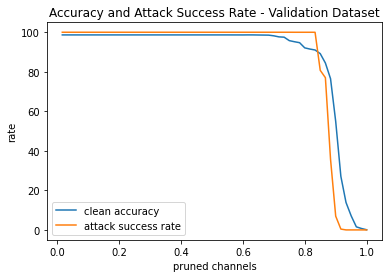

In [53]:
x_axis = np.arange(1,61)/60
plt.plot(x_axis,cleanAccuracies)
plt.plot(x_axis,attackSuccessRates)
plt.legend(['clean accuracy','attack success rate'])
plt.xlabel("pruned channels")
plt.ylabel("rate")
plt.title("Accuracy and Attack Success Rate - Validation Dataset")

## Combined models
We will combine two models: 

B (original badnet model) and B' (pruned model). 

The goodnet is the combined model.

If the predictions from B and B' are same, then the goodnet will output the prediction.

If there is a backdoor input, the goodnet will return 1283.

In [ ]:
class GoodNet(keras.Model):
  def __init__(self, B, BPruned):
      super(GoodNet, self).__init__()
      self.B = B
      self.BPruned = BPruned

  def predict(self,data):
      y = np.argmax(self.B(data), axis=1)
      yPruned = np.argmax(self.BPruned(data), axis=1)
      pred = np.zeros(data.shape[0])
      
      for i in range(data.shape[0]):
        if y[i] == yPruned[i]:
          pred[i] = y[i]
        else:
          pred[i] = 1283
      return pred

## Evaluate the combined model

In [ ]:
testDataPath = '/content/gdrive/MyDrive/ml-cs-lab3/cl/test.h5'
poisonedTestDataPath = '/content/gdrive/MyDrive/ml-cs-lab3/bd/bd_test.h5'

In [ ]:
testModel_X2_Path = '/content/gdrive/MyDrive/ml-cs-lab3/models/model_X=2.h5'
testModel_X4_Path = '/content/gdrive/MyDrive/ml-cs-lab3/models/model_X=4.h5'
testModel_X10_Path = '/content/gdrive/MyDrive/ml-cs-lab3/models/model_X=10.h5'

In [ ]:
testModel_X2 = keras.models.load_model(testModel_X2_Path)
testModel_X4 = keras.models.load_model(testModel_X4_Path)
testModel_X10 = keras.models.load_model(testModel_X10_Path)

In [ ]:
xTestData, yTestData = loadData(testDataPath)
xTestPoisonedData, yTestPoisonedData = loadData(poisonedTestDataPath)

In [ ]:
print("xTestData shape: ",xTestData.shape)
print("xTestPoisonedData shape: ",xTestPoisonedData.shape)

xTestData shape:  (12830, 55, 47, 3)
xTestPoisonedData shape:  (12830, 55, 47, 3)


In [ ]:
GoodNetModel_X2 = GoodNet(model, testModel_X2)
GoodNetModel_X4 = GoodNet(model, testModel_X4)
GoodNetModel_X10 = GoodNet(model, testModel_X10)

Evaluate on the test dataset

In [ ]:
cleanTest2LabelP = np.argmax(testModel_X2.predict(xTestData), axis=1)
cleanTest2Accuracy = np.mean(np.equal(cleanTest2LabelP, yTestData))*100

badTest2LabelP = np.argmax(testModel_X2.predict(xTestPoisonedData), axis=1)
asr2 = np.mean(np.equal(badTest2LabelP, yTestPoisonedData))*100

print('\n2% drops model, \nClassification Accuracy:', cleanTest2Accuracy)
print('Attack Success Rate:', asr2)


2% drops model, 
Classification Accuracy: 95.90023382696803
Attack Success Rate: 100.0


In [ ]:
cleanTest4LabelP = np.argmax(testModel_X4.predict(xTestData), axis=1)
cleanTest4Accuracy = np.mean(np.equal(cleanTest4LabelP, yTestData))*100

badTest4LabelP = np.argmax(testModel_X4.predict(xTestPoisonedData), axis=1)
asr4 = np.mean(np.equal(badTest4LabelP, yTestPoisonedData))*100

print('\n4% drops model, \nClassification Accuracy:', cleanTest4Accuracy)
print('Attack Success Rate:', asr4)


4% drops model, 
Classification Accuracy: 92.29150428682775
Attack Success Rate: 99.98441153546376


In [ ]:
cleanTest10LabelP = np.argmax(testModel_X10.predict(xTestData), axis=1)
cleanTest10Accuracy = np.mean(np.equal(cleanTest10LabelP, yTestData))*100

badTest10LabelP = np.argmax(testModel_X10.predict(xTestPoisonedData), axis=1)
asr10 = np.mean(np.equal(badTest10LabelP, yTestPoisonedData))*100

print('\n10% drops model, \nClassification Accuracy:', cleanTest10Accuracy)
print('Attack Success Rate:', asr10)


10% drops model, 
Classification Accuracy: 84.54403741231489
Attack Success Rate: 77.20966484801247


In [41]:
testAccuracies = [cleanTest2Accuracy, cleanTest4Accuracy, cleanTest10Accuracy]
attackRates = [asr2, asr4, asr10]
data = {
    "Test Accuracy": testAccuracies,
    "Attack Rate": attackRates,
    "Model": ["repaired_2%", "repaired_4%", "repaired_10%"]
}
df = pd.DataFrame(data)
df.set_index('Model')

,Test Accuracy,Attack Rate
Model,,
repaired_2%,95.900234,100.000000
repaired_4%,92.291504,99.984412
repaired_10%,84.544037,77.209665


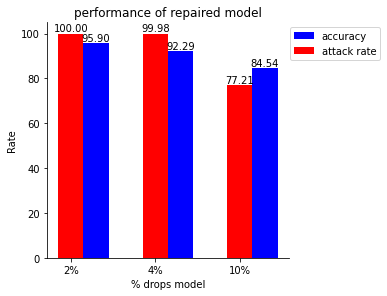

In [48]:
bar_width = 0.3

plt.xlabel('% drops model')
plt.ylabel('Rate')

plt.xticks(range(len(testAccuracies)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(testAccuracies)) + bar_width, testAccuracies, bar_width, align='center',color='b', label='accuracy')
bar2 = plt.bar(range(len(attackRates)), attackRates, bar_width, align='center', color='r', label='attack rate')

# Add counts above the two bar graphs
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of repaired model')
sns.despine()
plt.show()

In [49]:
GoodNetCleanTest2LabelP = GoodNetModel_X2.predict(xTestData)
GoodNetCleanTest2Accuracy = np.mean(np.equal(cleanTest2LabelP, yTestData))*100
print('Combined 2% drops model, the clean test data Classification accuracy:', GoodNetCleanTest2Accuracy)

GoodNet_badTest2LabelP = GoodNetModel_X2.predict(xTestPoisonedData)
GoodNetAsr2 = np.mean(np.equal(badTest2LabelP, yTestPoisonedData))*100
print('Combined 2% drops model, Attack Success Rate:', GoodNetAsr2)

Combined 2% drops model, the clean test data Classification accuracy: 95.90023382696803
Combined 2% drops model, Attack Success Rate: 100.0


In [50]:
GoodNetCleanTest4LabelP = GoodNetModel_X4.predict(xTestData)
GoodNetCleanTest4Accuracy = np.mean(np.equal(cleanTest4LabelP, yTestData))*100
print('Combined 4% drops model, the clean test data Classification accuracy:', GoodNetCleanTest4Accuracy)

GoodNetBadTest4LabelP = GoodNetModel_X4.predict(xTestPoisonedData)
GoodNetAsr4 = np.mean(np.equal(badTest4LabelP, yTestPoisonedData))*100
print('Combined 4% drops model, Attack Success Rate:', GoodNetAsr4)

Combined 4% drops model, the clean test data Classification accuracy: 92.29150428682775
Combined 4% drops model, Attack Success Rate: 99.98441153546376


In [51]:
GoodNet_cleanTest10LabelP = GoodNetModel_X10.predict(xTestData)
GoodNet_cleanTest10Accuracy = np.mean(np.equal(cleanTest10LabelP, yTestData))*100
print('Combined 10% drops model, the clean test data Classification accuracy:', GoodNet_cleanTest10Accuracy)

GoodNet_badTest10LabelP = GoodNetModel_X10.predict(xTestPoisonedData)
GoodNetAsr10 = np.mean(np.equal(badTest10LabelP, yTestPoisonedData))*100
print('Combined 10% drops model, Attack Success Rate:', GoodNetAsr10)

Combined 10% drops model, the clean test data Classification accuracy: 84.54403741231489
Combined 10% drops model, Attack Success Rate: 77.20966484801247


In [52]:
GoodNetTestAccuracies = [GoodNetCleanTest2Accuracy, GoodNetCleanTest4Accuracy, GoodNet_cleanTest10Accuracy]
GoodNetAttackRates = [GoodNetAsr2, GoodNetAsr4, GoodNetAsr10]
GoodNetData = {
    "GoodNet_text_acc": GoodNetTestAccuracies,
    "GoodNetAttackRates": GoodNetAttackRates,
    "GoodNetModel": ["GoodNet_2%", "GoodNet_4%", "GoodNet_10%"]
}
GoodNet_df = pd.DataFrame(GoodNetData)
GoodNet_df.set_index('GoodNetModel')

,GoodNet_text_acc,GoodNetAttackRates
GoodNetModel,,
GoodNet_2%,95.900234,100.000000
GoodNet_4%,92.291504,99.984412
GoodNet_10%,84.544037,77.209665


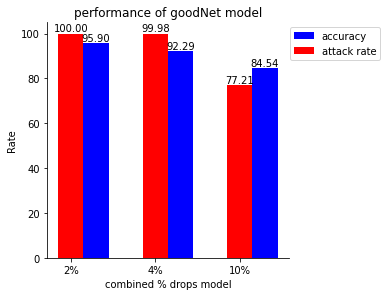

In [47]:
bar_width = 0.3

plt.xlabel('combined % drops model')
plt.ylabel('Rate')

plt.xticks(range(len(GoodNetTestAccuracies)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(GoodNetTestAccuracies)) + bar_width, GoodNetTestAccuracies, bar_width, align='center', color='b', label='accuracy')
bar2 = plt.bar(range(len(GoodNetAttackRates)),GoodNetAttackRates, bar_width, align='center', color='r', label='attack rate')

# Add counts above the two bar graphs
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of goodNet model')
sns.despine()
plt.show()

We can see that the prune defense is not too successful here. I think the attack is prune aware attack that the pruned model is retrained with poisoned data. And the weight is changed again so that the model will have the wrong predition.  